# Nuterient Gap Prediction

This notebook aims to predicts the availability of 11 essential soil nutrients and calculates the nutrient gaps required for maize crops to achieve a target yield of 4 tons per hectare.

We will follow a structured pipeline:

Data Preparation: Load training and testing datasets.
Exploratory Data Analysis (EDA): Understand patterns and relationships in the data.
Feature Engineering: Transform raw data into meaningful features.
Model Training: Train multiple models using cross-validation and hyperparameter tuning.
Evaluation and Submission: Evaluate the best model and prepare predictions for submission.

## Imports

In [1]:
import sys 
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')  # To keep output clean
pd.pandas.set_option('display.max_columns', None)

project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.dataset import load_data, wrangle_data, save_processed_data
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, logger

2025-07-09 16:47:00.764 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /Users/omorinsolamakinde/nutrient-gap


## Load Data 

In [2]:
train_df = load_data("Train-2.csv", data_type="raw")
test_df = load_data("Test.csv",data_type="raw")
train_gap_df = load_data("Gap_Train.csv", data_type="raw")
test_gap_df = load_data("Gap_Test.csv", data_type="raw")

2025-07-09 16:47:05.804 | INFO     | src.dataset:load_data:25 - loading data from/Users/omorinsolamakinde/nutrient-gap/data/raw/Train-2.csv
2025-07-09 16:47:05.880 | INFO     | src.dataset:load_data:25 - loading data from/Users/omorinsolamakinde/nutrient-gap/data/raw/Test.csv
2025-07-09 16:47:05.951 | INFO     | src.dataset:load_data:25 - loading data from/Users/omorinsolamakinde/nutrient-gap/data/raw/Gap_Train.csv
2025-07-09 16:47:06.022 | INFO     | src.dataset:load_data:25 - loading data from/Users/omorinsolamakinde/nutrient-gap/data/raw/Gap_Test.csv


In [3]:
test_gap_df.head()

,Nutrient,Required,PID
0,N,100.0,ID_NGS9Bx
1,P,40.0,ID_NGS9Bx
2,K,52.0,ID_NGS9Bx
3,Ca,12.0,ID_NGS9Bx
4,Mg,8.0,ID_NGS9Bx


In [5]:
train_gap_df.head()

,Nutrient,Required,Available,Gap,PID
0,N,100.0,3796.0000,-3696.0000,ID_I5RGjv
1,P,40.0,0.9928,39.0072,ID_I5RGjv
2,K,52.0,429.2400,-377.2400,ID_I5RGjv
3,Ca,12.0,19943.6000,-19931.6000,ID_I5RGjv
4,Mg,8.0,6745.2000,-6737.2000,ID_I5RGjv


In [6]:
train_df.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,1300,0.34,147,6830,2310,5.66,75.2,85.0,0.82,2.98,0.24
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,1400,11.70,151,1180,235,19.40,96.2,409.0,2.57,4.32,0.10
2,site_id_nGvnKc,ID_UgzkN8,70.582553,46.048820,6.95,188,250,1109,111,191,0.362439,15.25,18.900057,16.062401,0.06240,0.030000,44.167717,19.413284,1639.999634,2903.000000,758.999939,2003.999878,1074,24.719807,214.385269,6.725,0.744845,46.00,9.25,8.289246,0.020588,0.003885,1.46,3500,21.80,151,1890,344,11.00,76.7,65.0,1.95,1.24,0.22
3,site_id_nGvnKc,ID_DLLHM9,70.573267,46.021910,7.83,174,250,1149,112,191,0.531739,22.00,17.022963,18.030899,0.03090,0.030000,43.281063,19.539835,1325.000122,2413.000244,631.999939,1961.000000,1044,27.230274,255.713043,6.625,0.708708,43.75,10.00,8.666523,0.016913,0.001714,1.48,2300,39.90,201,6660,719,14.90,81.9,73.0,4.90,3.08,0.87
4,site_id_7SA9rO,ID_d009mj,70.585330,46.204336,8.07,188,250,869,114,191,0.039202,14.75,23.103102,11.000000,0.00000,0.155324,45.654484,18.690720,1628.999512,2685.999023,732.999939,2427.000000,1055,20.434782,86.220909,6.700,0.634153,49.25,7.00,15.139549,0.019791,0.000000,1.43,940,1.00,90,7340,1160,8.66,69.4,149.0,0.55,3.03,0.31


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744 entries, 0 to 7743
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site         7744 non-null   object 
 1   PID          7744 non-null   object 
 2   lon          7744 non-null   float64
 3   lat          7744 non-null   float64
 4   pH           7744 non-null   float64
 5   alb          7744 non-null   int64  
 6   bio1         7744 non-null   int64  
 7   bio12        7744 non-null   int64  
 8   bio15        7744 non-null   int64  
 9   bio7         7744 non-null   int64  
 10  bp           7744 non-null   float64
 11  cec20        7744 non-null   float64
 12  dows         7744 non-null   float64
 13  ecec20       7739 non-null   float64
 14  hp20         7739 non-null   float64
 15  ls           7744 non-null   float64
 16  lstd         7744 non-null   float64
 17  lstn         7744 non-null   float64
 18  mb1          7744 non-null   float64
 19  mb2   

### Insight

The dataset contains 7,744 rows and 44 columns.

32 columns are of type float64 (decimal numbers)
10 columns are of type int64 (whole numbers)
2 columns are of type object (typically text or categorical data)
There are also missing values present in some columns.

In [8]:
# check missing values
train_df.isnull().sum().sum()
print(train_df.isnull().sum())

site           0
PID            0
lon            0
lat            0
pH             0
alb            0
bio1           0
bio12          0
bio15          0
bio7           0
bp             0
cec20          0
dows           0
ecec20         5
hp20           5
ls             0
lstd           0
lstn           0
mb1            0
mb2            0
mb3            0
mb7            0
mdem           0
para           0
parv           0
ph20           0
slope          0
snd20          0
soc20          0
tim            0
wp             0
xhp20          5
BulkDensity    4
N              0
P              0
K              0
Ca             0
Mg             0
S              0
Fe             0
Mn             0
Zn             0
Cu             0
B              0
dtype: int64


In [8]:
features_with_na = [features for features in train_df.columns if train_df[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, np.round(train_df[feature].isnull().mean(), 4), '% missing values')

ecec20 0.0006 % missing values
hp20 0.0006 % missing values
xhp20 0.0006 % missing values
BulkDensity 0.0005 % missing values


## Visualizing Missing Values vs Targets


This is to find out if the missing values have an effect on the target variables .Knowing this will help to decide how to handle it

In [9]:
target_list = ['N', 'P', 'K','Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

def analyse_missing_vs_targets(df, feature, target_list):
    data = df.copy()

    # Mark missing = 1, not missing = 0
    data['missing_flag'] = np.where(data[feature].isnull(), 1, 0)

    for t in target_list:
        data.groupby('missing_flag')[t].median().plot.bar()
        plt.title(f"Median of {t} vs Missingness in {feature}")
        plt.xlabel(f"Missing in {feature} (0 = No, 1 = Yes)")
        plt.ylabel(f"Median of {t}")
        plt.show()


**Missing Values in ecec20 Vs target variables**

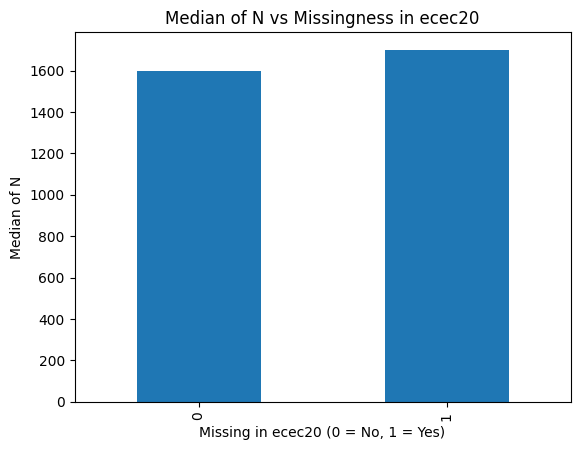

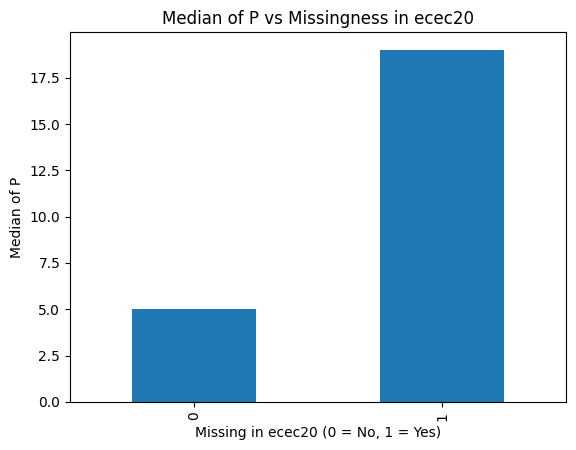

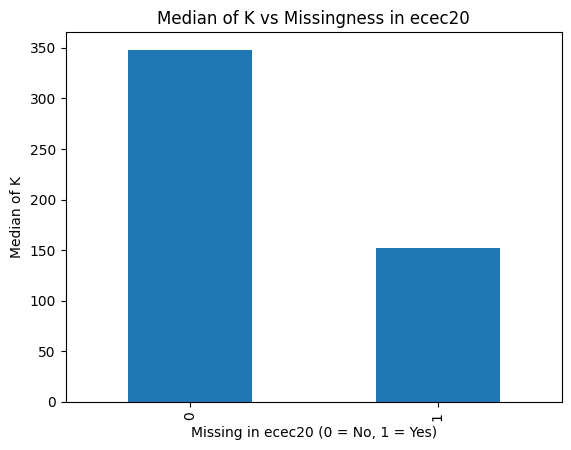

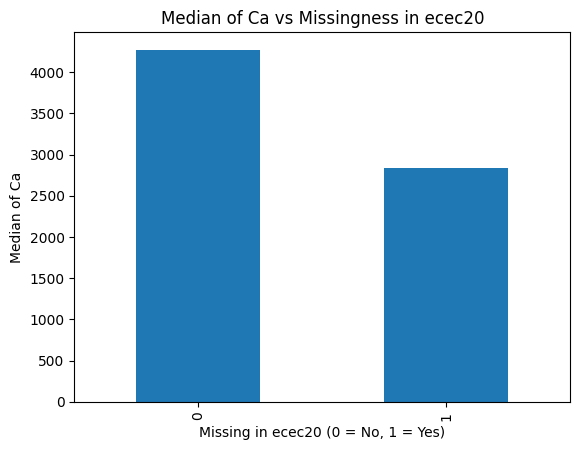

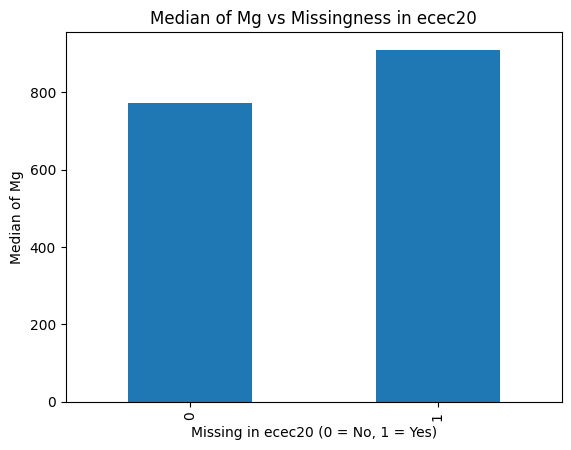

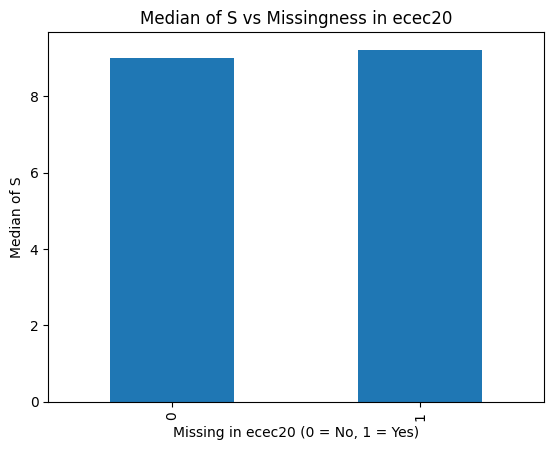

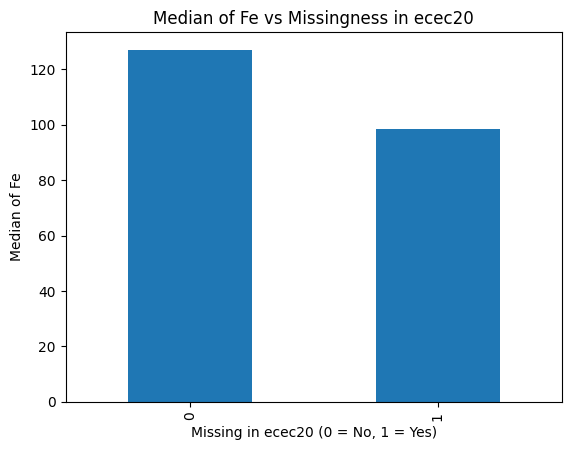

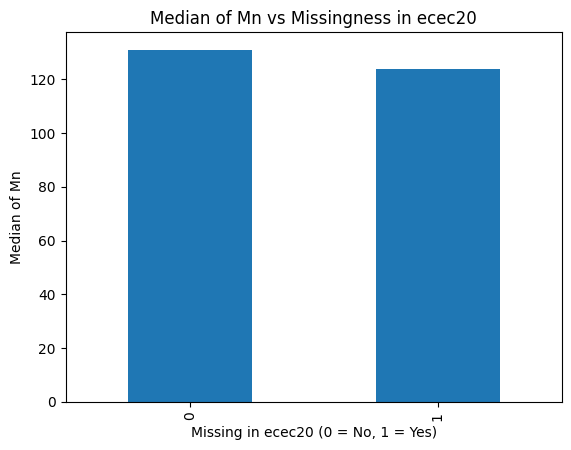

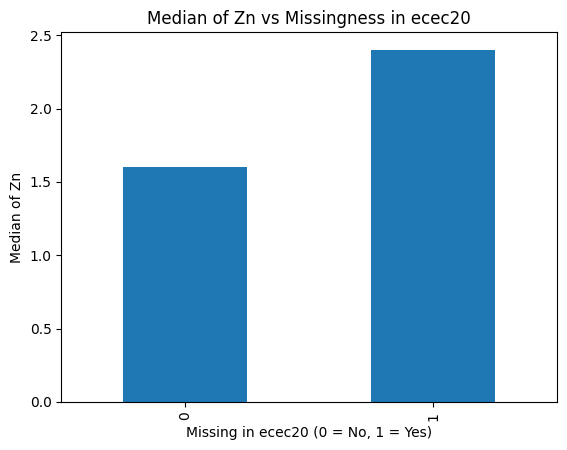

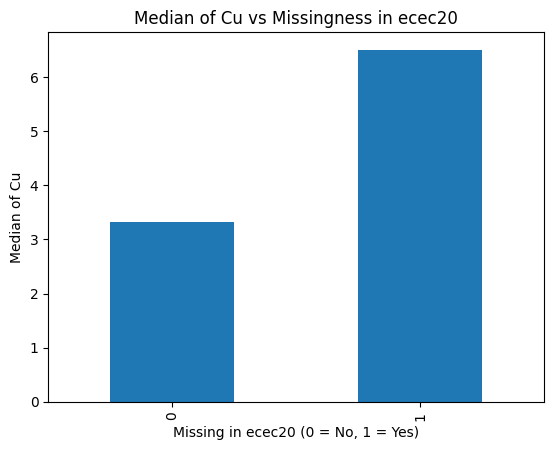

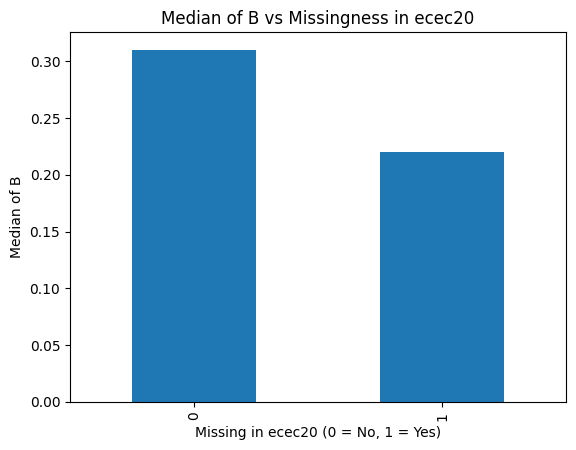

In [10]:
analyse_missing_vs_targets(train_df,'ecec20', target_list)

**Missing Values in hp20 Vs target variables**

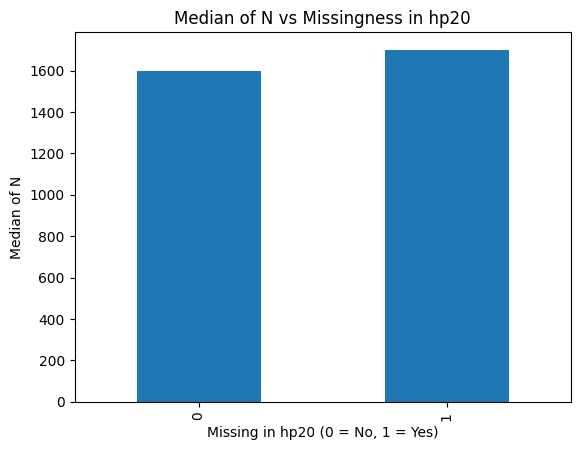

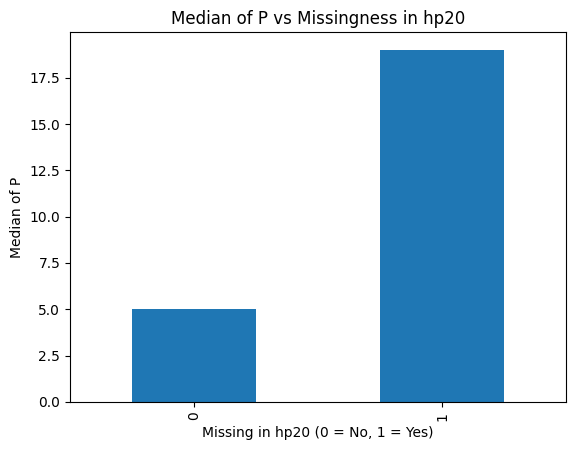

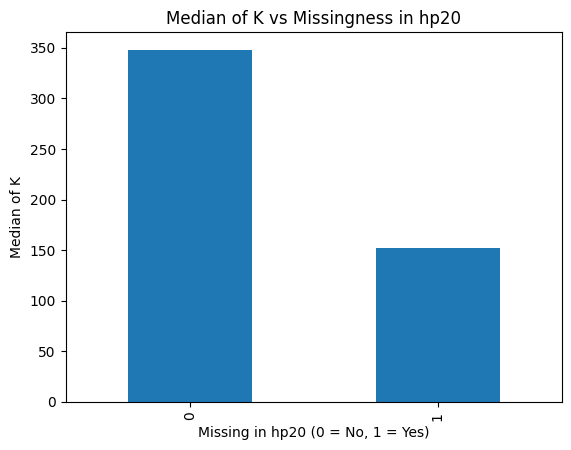

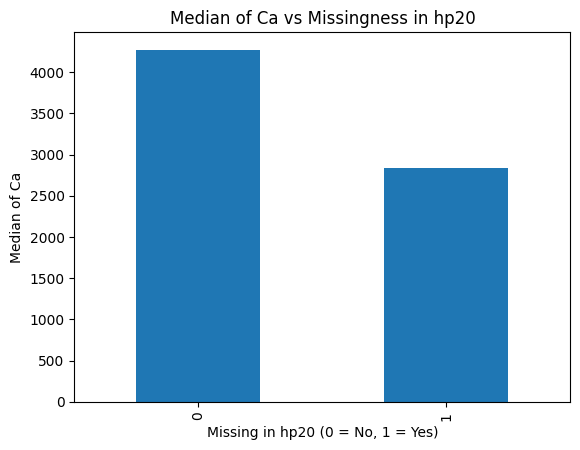

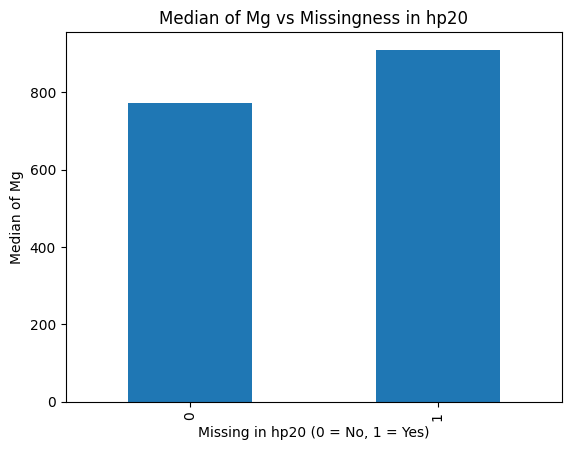

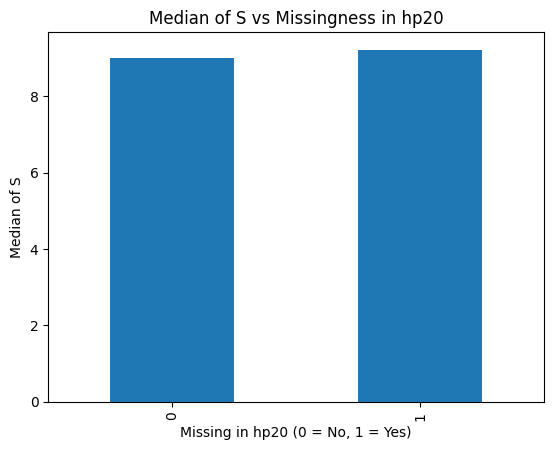

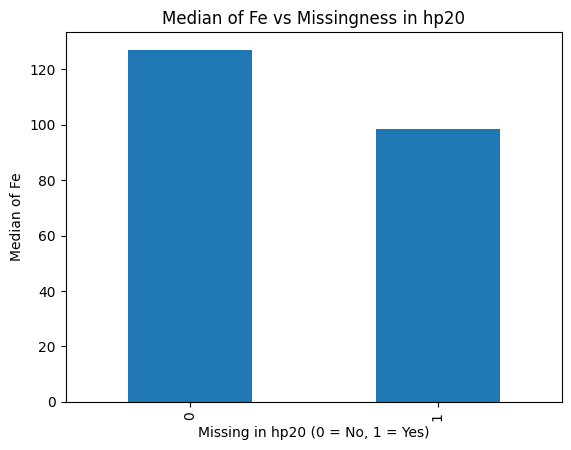

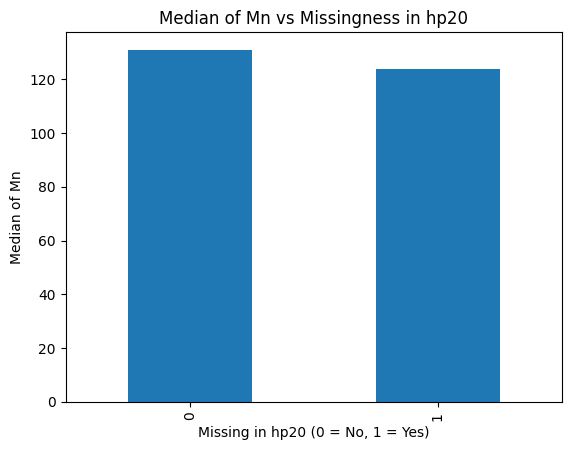

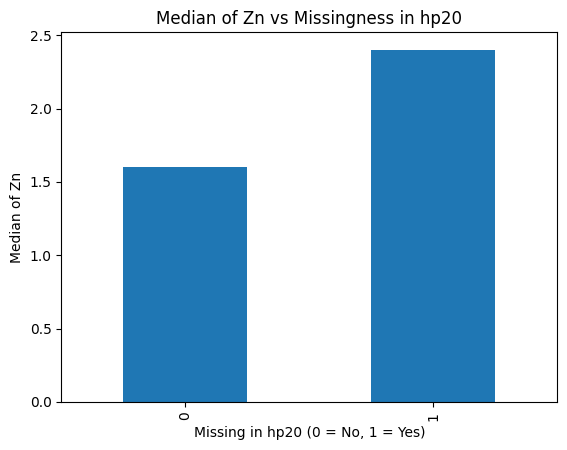

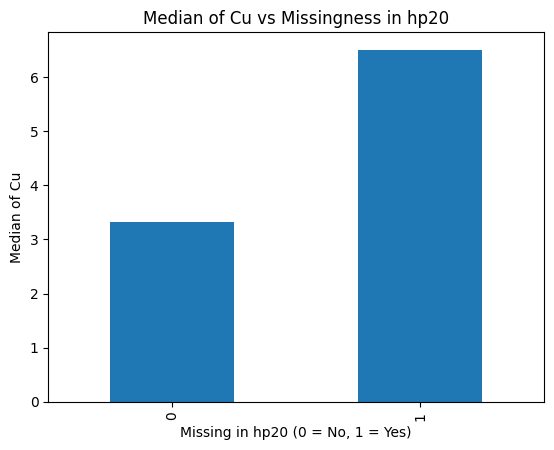

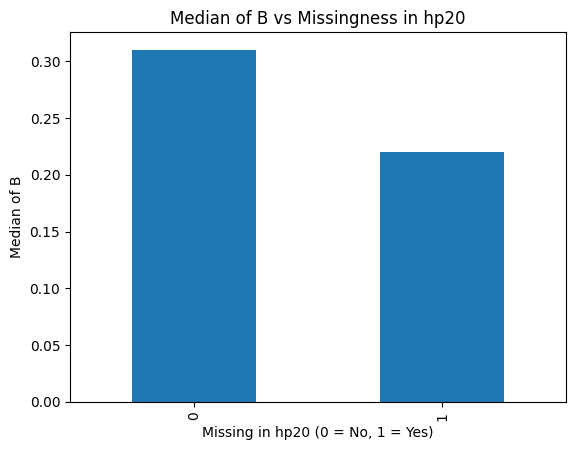

In [11]:
analyse_missing_vs_targets(train_df,'hp20', target_list)

**Missing Values in xhp20 Vs target variables**

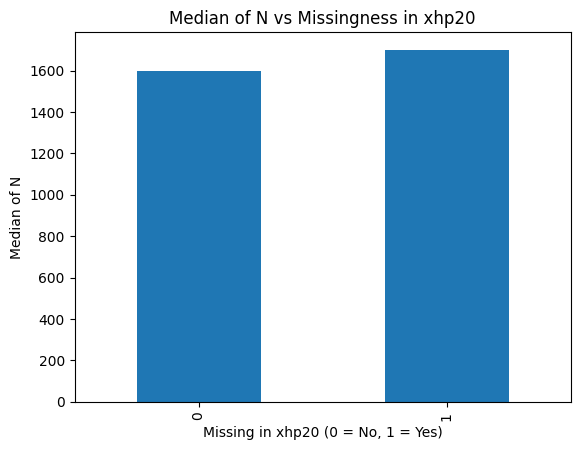

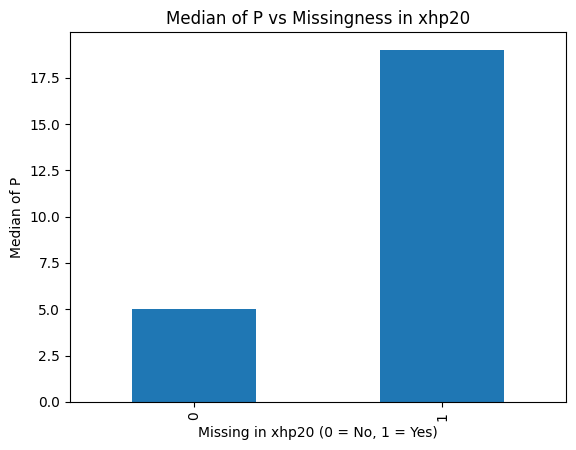

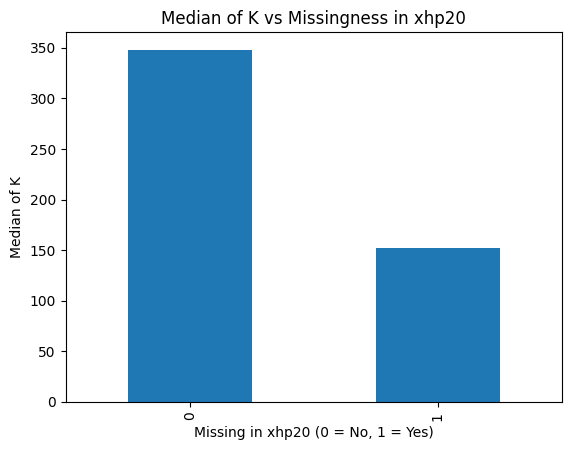

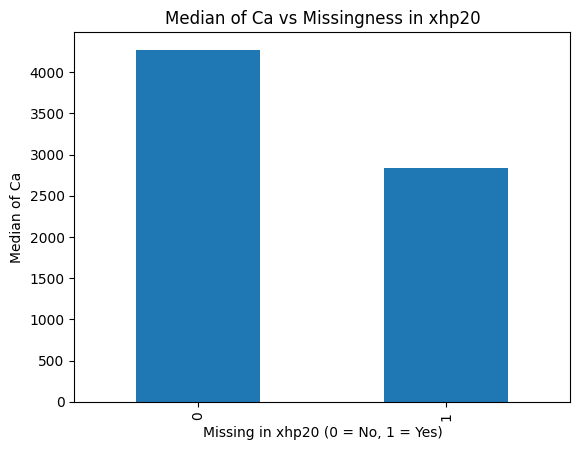

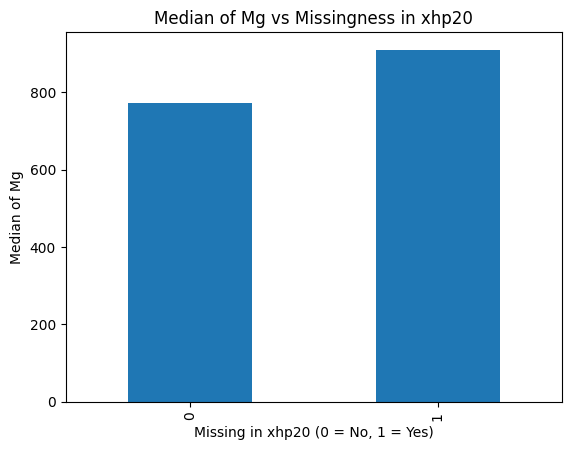

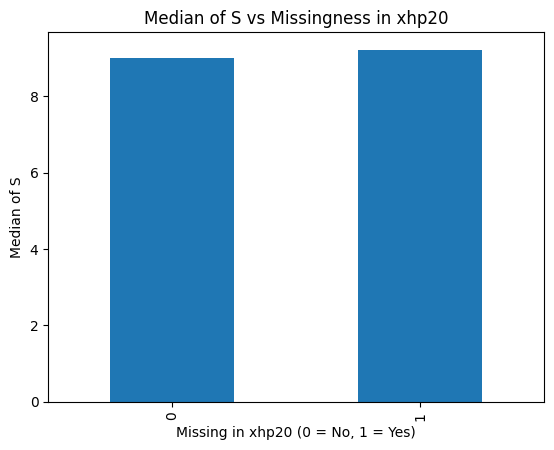

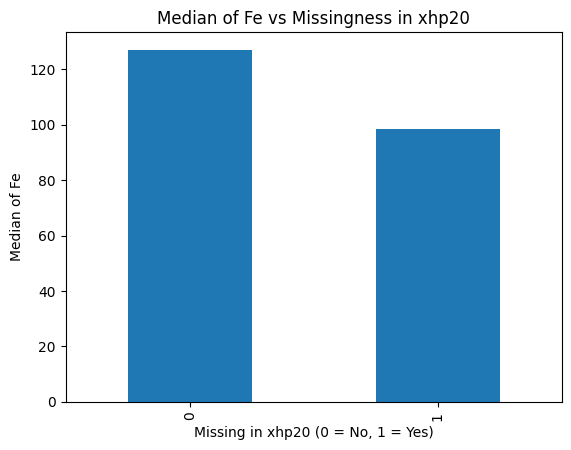

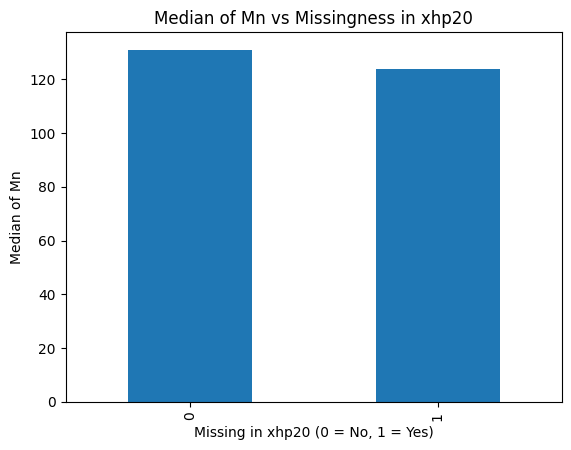

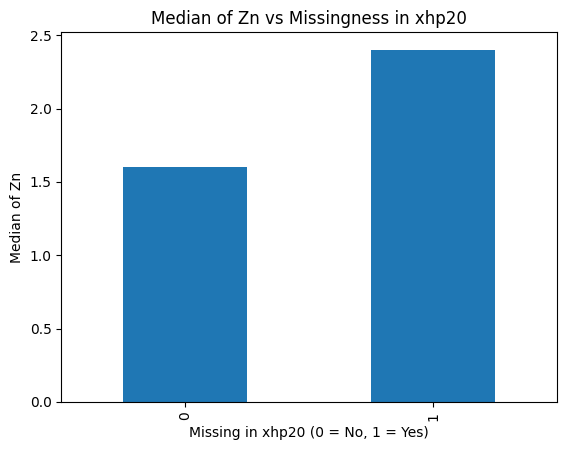

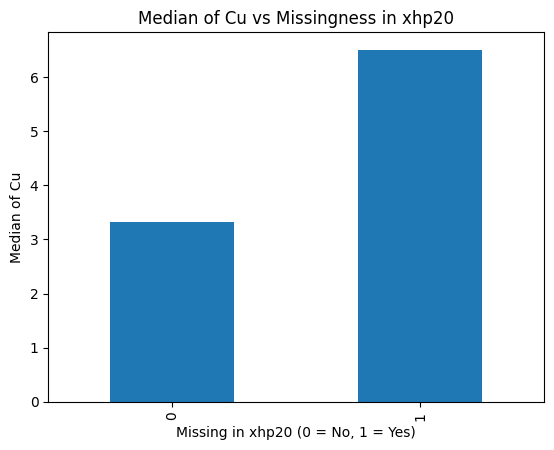

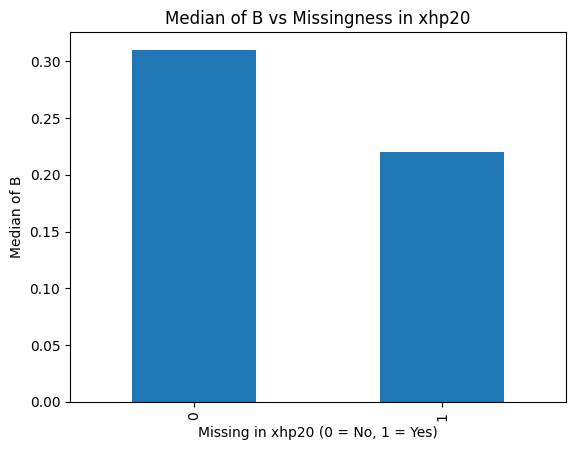

In [12]:
analyse_missing_vs_targets(train_df,'xhp20', target_list)

**Missing Values in Bulk Density Vs target variables**

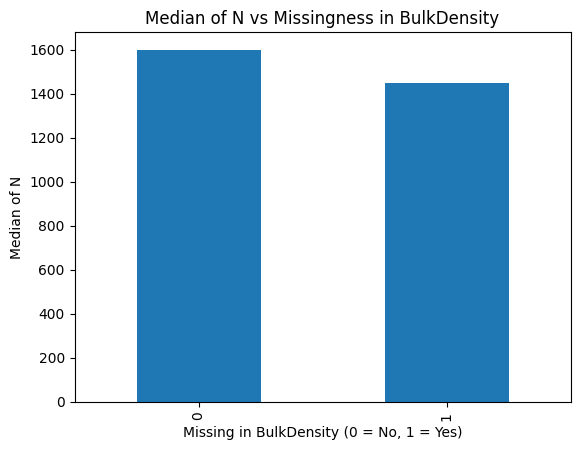

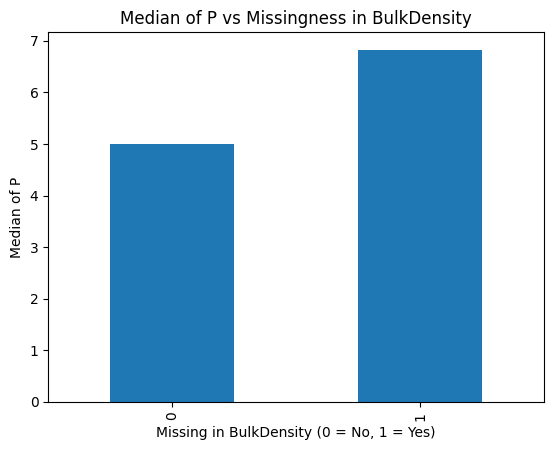

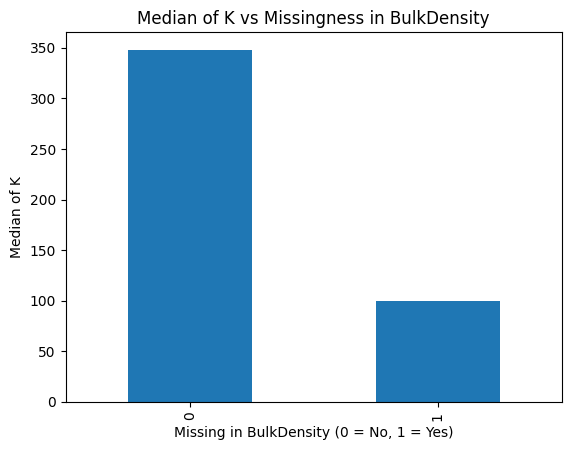

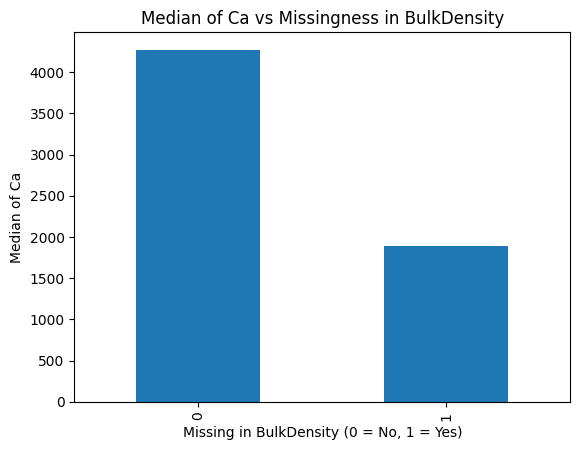

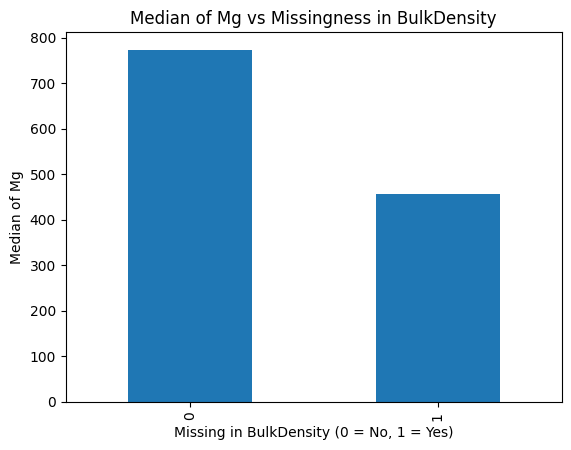

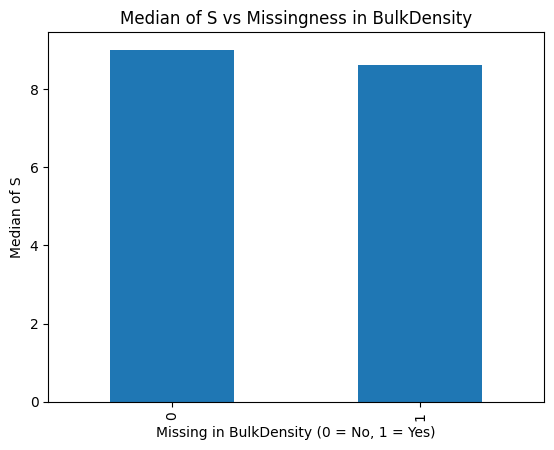

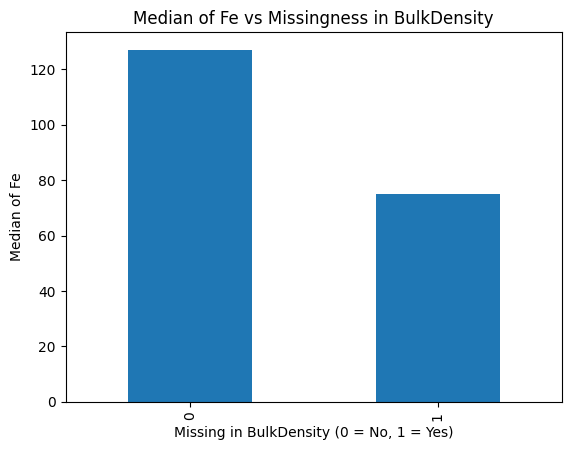

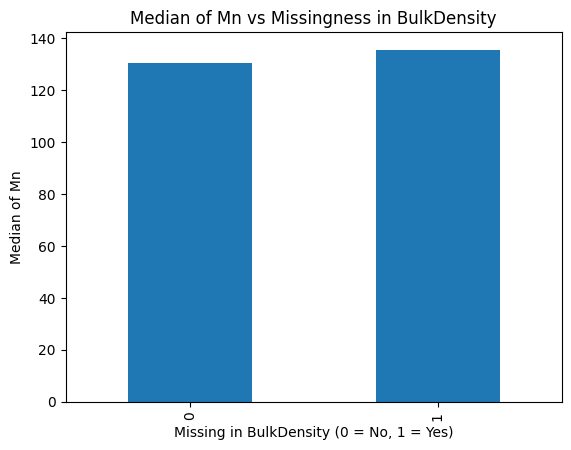

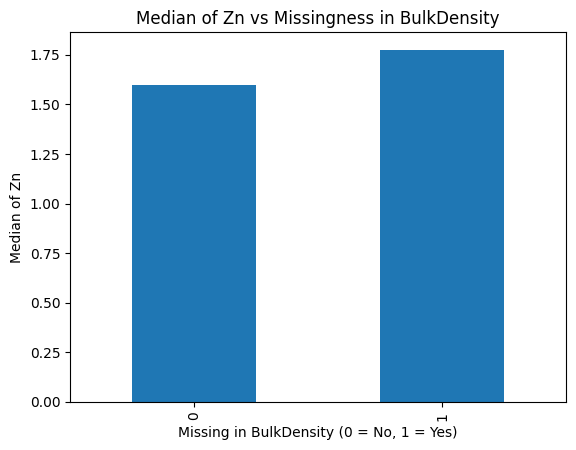

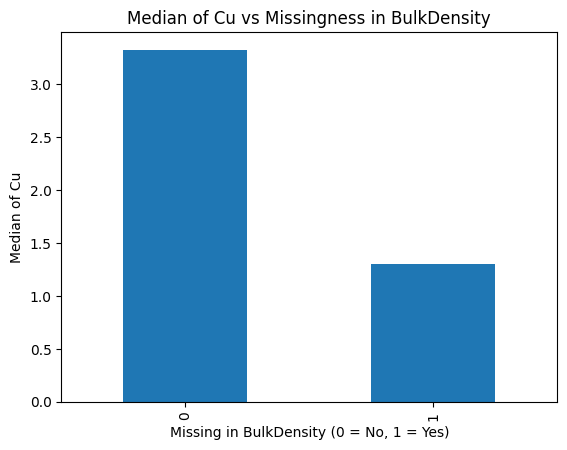

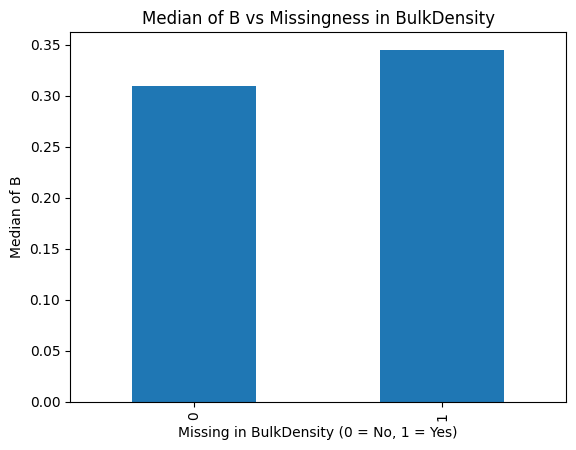

In [13]:
analyse_missing_vs_targets(train_df,'BulkDensity', target_list)

**Insight:**
Missing values in ecec20, hp20, and xhp20 show clear patterns with some target variables, which means the missing values might not be random. For N and S, the difference is small. Also, hp20 and xhp20 often have missing values in the same rows. For bulk density, the missing values also show a clear link with the targets. We'll need to handle these missing values carefully during feature engineering.



### Categorical variables

In [14]:
print(f"PID OF unique PID(soil sample) {train_df['PID'].nunique()}")
print(f"number of unique site: {train_df['site'].nunique()}")


PID OF unique PID(soil sample) 7744
number of unique site: 819


In [15]:
numerical_features = train_df.select_dtypes(include='number').columns
numerical_features

Index(['lon', 'lat', 'pH', 'alb', 'bio1', 'bio12', 'bio15', 'bio7', 'bp',
       'cec20', 'dows', 'ecec20', 'hp20', 'ls', 'lstd', 'lstn', 'mb1', 'mb2',
       'mb3', 'mb7', 'mdem', 'para', 'parv', 'ph20', 'slope', 'snd20', 'soc20',
       'tim', 'wp', 'xhp20', 'BulkDensity', 'N', 'P', 'K', 'Ca', 'Mg', 'S',
       'Fe', 'Mn', 'Zn', 'Cu', 'B'],
      dtype='object')

In [16]:
discrete_features=[features for features in numerical_features if len(train_df[feature].unique())< 25]
discrete_features
print(len(discrete_features))

0


### Univariate Analysis

In [17]:
# summary statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,7744.0,70.653017,0.860192,69.300473,69.971547,70.448565,71.323206,73.111835
lat,7744.0,41.973038,1.569701,39.265792,40.746015,41.666340,43.117872,46.460178
pH,7744.0,6.447565,1.002991,3.720000,5.600000,6.370000,7.200000,9.660000
alb,7744.0,139.222882,14.849485,94.000000,129.000000,139.000000,148.000000,208.000000
bio1,7744.0,174.123450,27.681376,78.000000,156.000000,172.000000,189.000000,280.000000
bio12,7744.0,1203.880036,291.677540,500.000000,975.000000,1189.000000,1412.000000,2196.000000
bio15,7744.0,94.766012,18.142568,43.000000,84.000000,95.000000,107.000000,160.000000
bio7,7744.0,159.381586,12.229591,129.000000,152.000000,157.000000,164.000000,200.000000
bp,7744.0,0.442799,0.273370,0.030137,0.186838,0.419025,0.683969,0.961943
cec20,7744.0,42.517691,7.336181,0.000000,38.750000,43.250000,47.000000,78.000000


In [18]:
fig = px.scatter_mapbox(
    train_df,  # Our DataFrame
    lat="lat",
    lon="lon",
    # center={"lat": 1.5, "lon": 17.5}, # Map will be centered on Mexico City
    width=600,  # Width of map
    height=600,  # Height of map
    hover_data=["BulkDensity"],  # Display price when hovering mouse over house
)

# Add mapbox_style to figure layout
fig.update_layout(mapbox_style="open-street-map")

# Show figure
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Insight

Location: The farm coordinates suggest locations in Kazakhstan, which is unexpected since the data was described as collected across Africa

Ph: For maize cultivation, the ideal soil pH typically ranges from 6.0 to 6.5, with an acceptable range between 5.5 and 7.3. Based on the data, most samples fall within this optimal window. However, some soils are highly acidic (minimum pH observed: 3.7) or slightly too alkaline (maximum pH: 9.66), which may require soil treatment for optimal maize growth.Soil pH levels that are too high or too low could lead to a deficiency of many nutrients.

alb:(sunlight reflection)ranges from 0.094 to 0.208, with an average of 0.139. This suggests that most of the fields in the dataset are absorbing a good amount of sunlight, which is typical for maize fields during their early or active growth stages. Lower albedo means more sunlight is absorbed by the soil,leading to warmer soil temperatures.

bio1: The mean annual temperature ranges from 7.8°C to 28.0°C, with an average around 17.4°C, indicating that most areas experience warm temperate conditions around.

bio12The mean annual precipitation is around 1,203 mm, ranging from 500 mm to 2,196 mm. Some sites get much more rainfall than others, which can affect soil moisture and crop growth differently.The lowest value (500 mm) may also be a potential outlier, as it’s quite far from the average.

bio15(rainfall seasonality): Most farms get rain in certain months and little in others . The average seasonality score is around 95,but it ranges from 43 to 160. This means some farm sites have more uneven rainfall across the year than others. High seasonality (closer to 160) suggests rain falls mostly in a short period,

In [ ]:
for col in numerical_features:
    plt.figure(figsize=(12, 5))

    # Histogram on the left
    plt.subplot(1, 2, 1)
    sns.histplot(data=train_df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.grid(True)

    # Boxplot on the right
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    # Display both plots in one figure
    plt.tight_layout()
    plt.show()

### Bivariate Analysis

**PH VS Soil nutrients**

Researh shows that availability of soil nutrients is affected by changes in soil pH in different ways.

we will visualize this

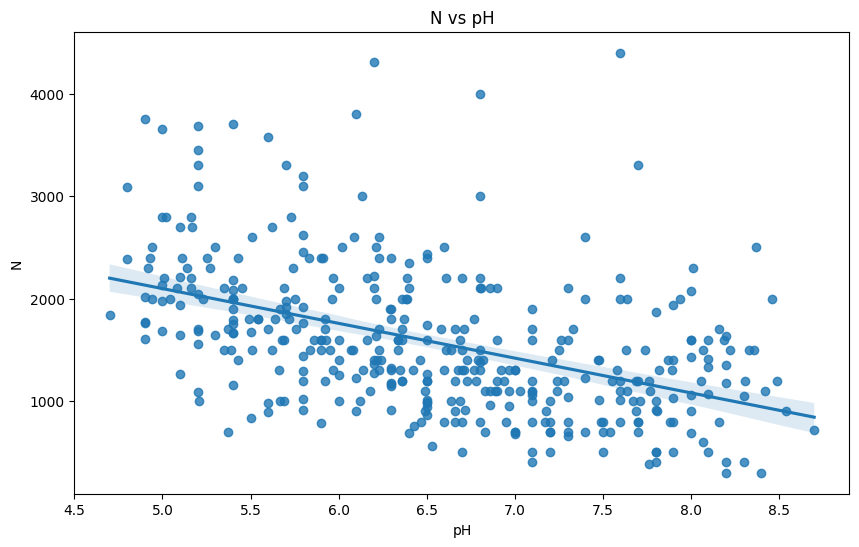

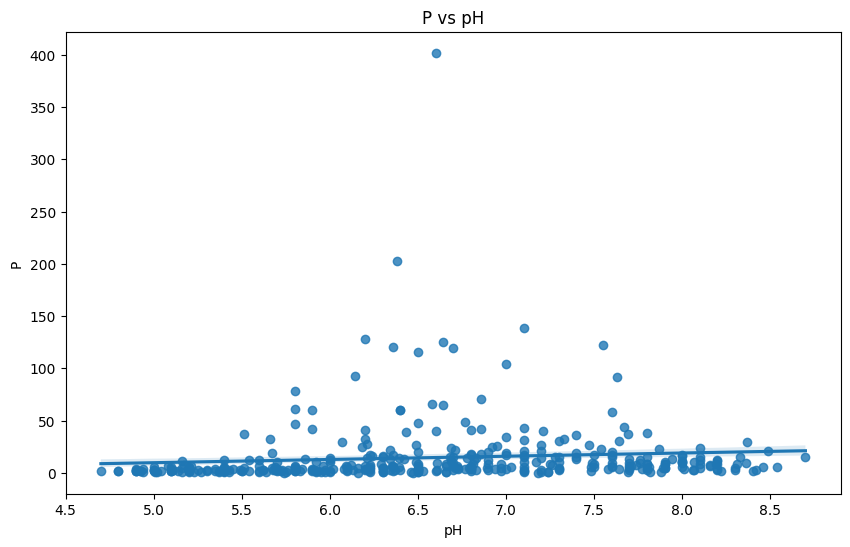

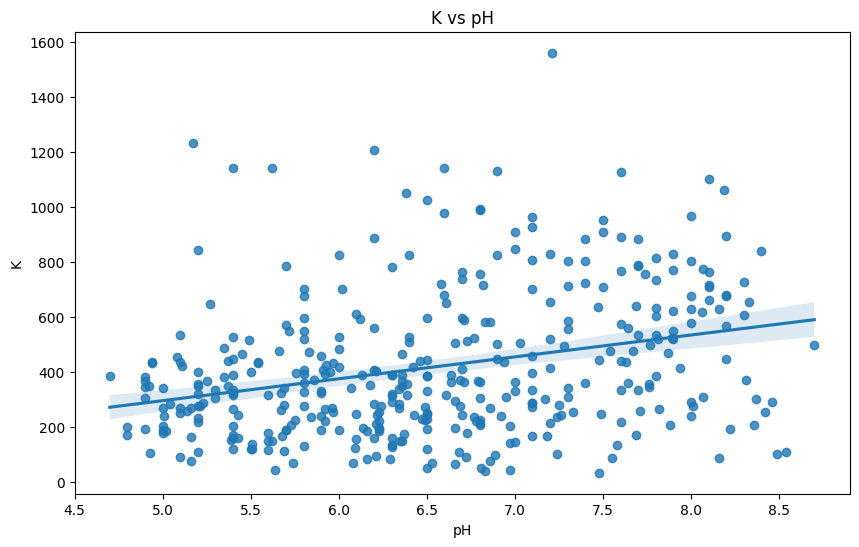

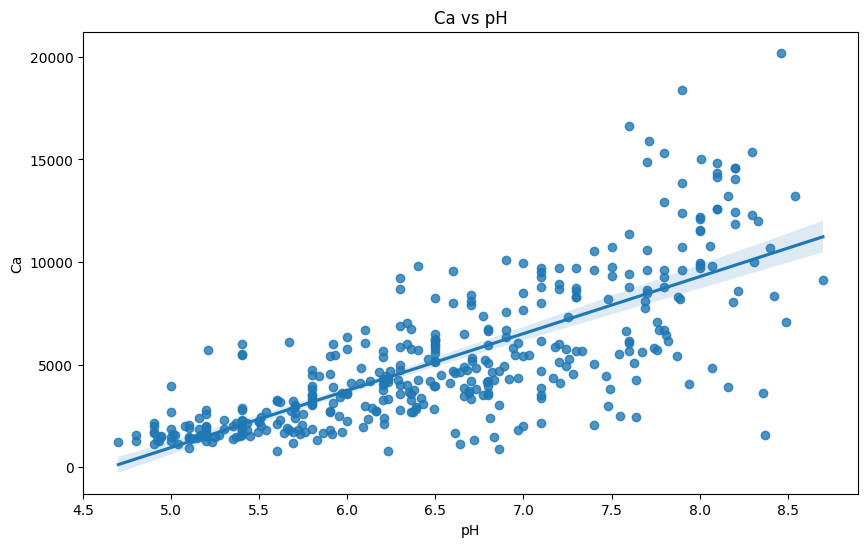

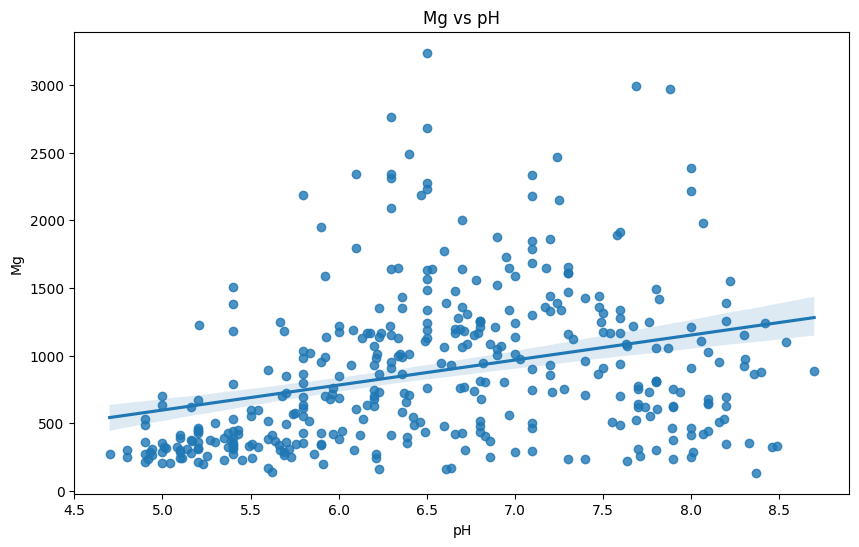

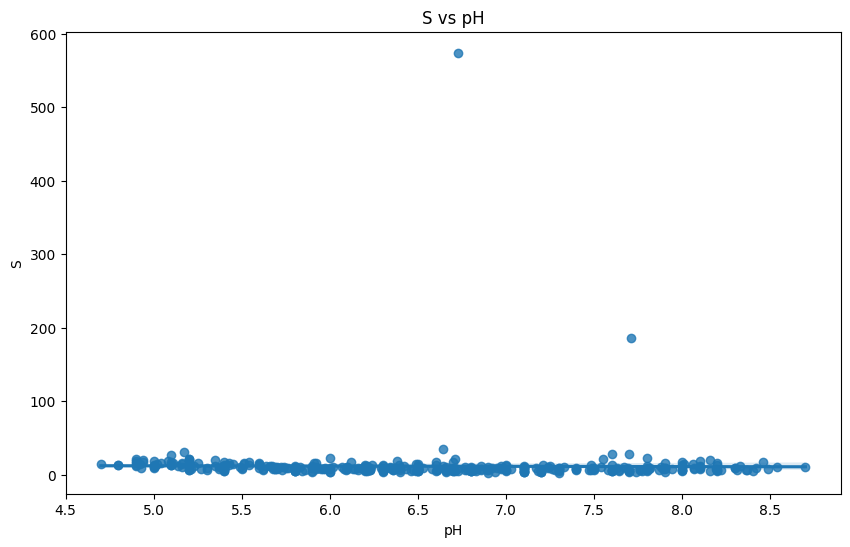

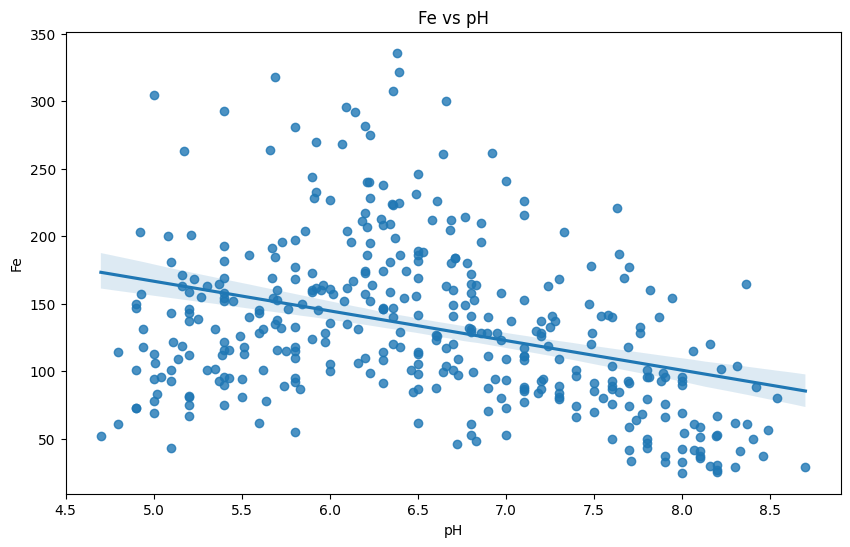

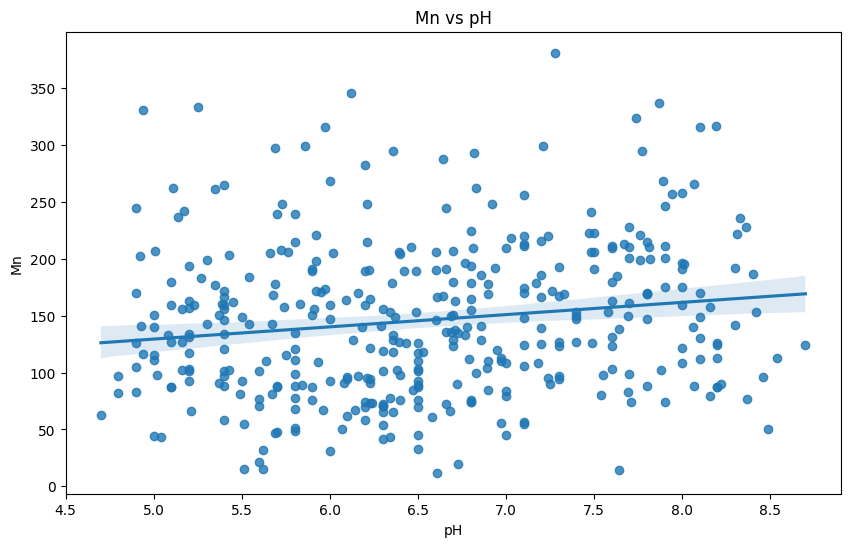

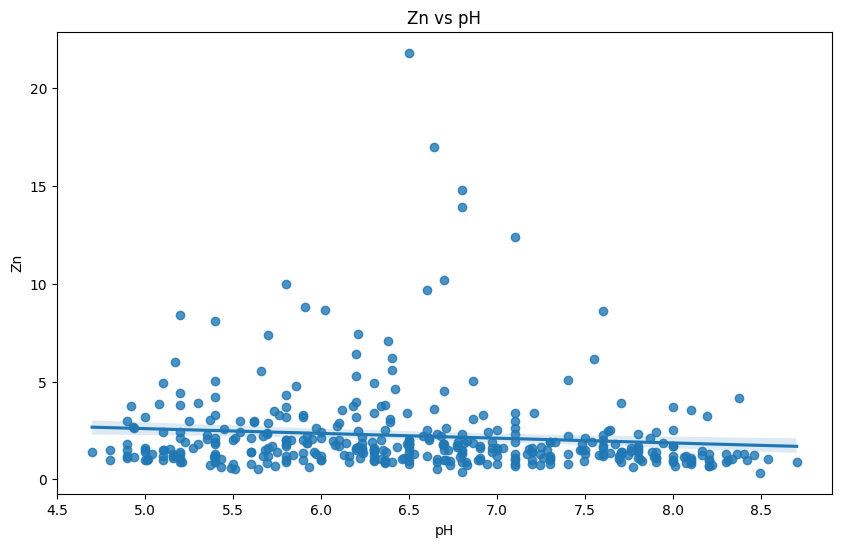

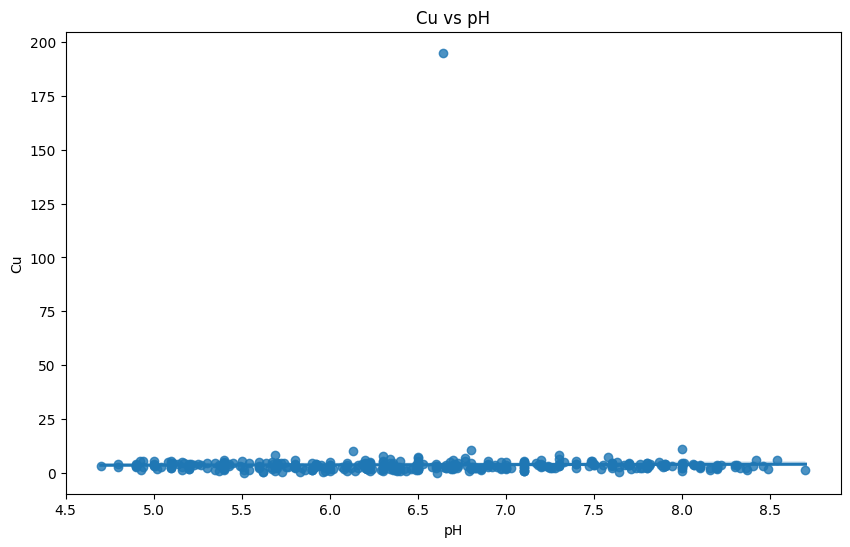

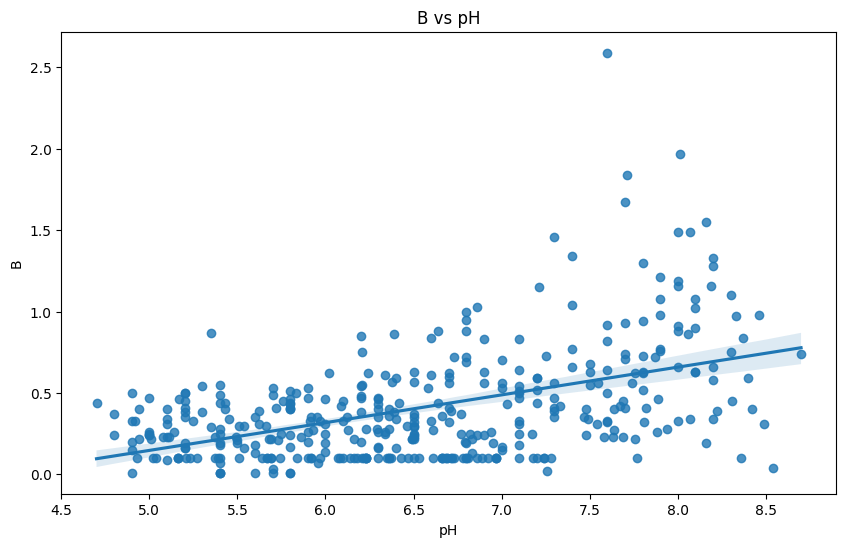

In [ ]:
for nutrient in target_list:
    plt.figure(figsize=(10, 6))
    sample_df = train_df.sample(frac=0.05, random_state=42)
    sns.regplot(x=sample_df['pH'], y=sample_df[nutrient])
    plt.title(f'{nutrient} vs pH')
    plt.xlabel('pH')
    plt.ylabel(nutrient)
    plt.show()

insight : there is a clear relationship between ph and majority of the nutrients . nutrients such as S and P have very week relationship with ph

### Multivariate  Analysis

In [ ]:
# Correlation
corr = train_df[numerical_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(30, 30))

# Draw the heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

plt.title("Triangular Correlation Heatmap")
plt.show()

There appears to be multicolinearity among these features
xhp20 and hp20 are highly correlated.,
1. mdem and bio1
2. mdem and lstn
3. lstn and bio1

4. mb7 and alb
5. mb7 and mb1
6. bio0 and lat

# Data Cleaning

In [7]:
clean_train_df = wrangle_data(train_df)
save_processed_data(clean_train_df, "clean_train.csv")
